## Load imports and functions

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import calendar
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [41]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [42]:

def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df


## Load and convert data

In [43]:
df = pd.read_csv("HNX.csv")

In [44]:
df = convert_raw_data(df)
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,179.84,168.58,179.84,168.47,26.86K,6.94%
1,2010-01-05,183.26,181.29,187.57,180.97,37.28K,1.90%
2,2010-01-06,179.56,184.78,185.50,179.48,41.57K,-2.02%
3,2010-01-07,177.95,180.82,183.24,177.89,36.69K,-0.90%
4,2010-01-08,179.76,179.76,186.01,175.59,43.84K,1.02%


## split training and testing data

In [45]:
ratio = 0.7
ratio = 0.8
ratio = 0.9
train_size = int(ratio * len(df))
test_size = int((1-ratio) * len(df))


train_data = df[:train_size]
test_data = df[train_size:]

## process data using logarithmic transformation

In [46]:
filtered_data = train_data[['Date', 'Open']].copy()
Q1 = filtered_data['Open'].quantile(0.25)
Q3 = filtered_data['Open'].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
df_no_outliers = filtered_data[~((filtered_data['Open'] < (Q1 - threshold * IQR)) | (filtered_data['Open'] > (Q3 + threshold * IQR)))]

## Training modal

In [47]:
df_no_outliers['Open_Log'] = np.log(df_no_outliers['Open'])
df_no_outliers.set_index('Date', inplace=True)

C:\Users\PH315-52\AppData\Local\Temp\ipykernel_29100\2609978933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Open_Log'] = np.log(df_no_outliers['Open'])


In [48]:
auto_arima1 = pmd.auto_arima(df_no_outliers['Open_Log'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-13213.255, Time=3.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-327.057, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-5596.556, Time=1.64 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13353.733, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-13215.252, Time=0.42 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-11565.016, Time=2.24 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-3283.219, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-13208.268, Time=2.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-13220.954, Time=1.13 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-11567.351, Time=3.45 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-13219.104, Time=6.18 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=7.88 se

In [49]:
auto_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2294
Model:               SARIMAX(1, 0, 3)   Log Likelihood                6618.264
Date:                Mon, 01 Jan 2024   AIC                         -13224.528
Time:                        05:58:24   BIC                         -13190.100
Sample:                             0   HQIC                        -13211.974
                               - 2294                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0121      0.004      2.747      0.006       0.003       0.021
ar.L1          0.9973      0.001   1054.294      0.000       0.995       0.999
ma.L1         -0.0222      0.014     -1.573      0.116      -0.050       0.005
ma.L2          0.0533      0.015      3.634      0.000       0.025       0.082
ma.L3          0.0497      0.014      3.428      0.001       0.021       0.078
sigma2         0.0002   3.43e-06     53.137      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               926.87
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Evaluating

In [50]:
history = [np.log(x) for x in train_data['Open']]
prediction_test = list()
y_test = list(np.log(test_data['Open']))
for t in range(len(test_data)):
    model = ARIMA(history, order=(0,1,0), seasonal_order = (1,0,0,12))
    model_fit = model.fit()
    yhat_p = model_fit.predict(start=(len(history)+1), end=(len(history)+2))[0]
    prediction_test.append(yhat_p)
    history.append(y_test[t])

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [52]:
prediction = np.exp(prediction_test)
predicted_df = pd.DataFrame({'Date': test_data['Date'], 'Open': prediction})

print(predicted_df)

           Date        Open
2438 2019-10-15  105.298601
2439 2019-10-16  106.068466
2440 2019-10-17  106.288120
2441 2019-10-18  105.977488
2442 2019-10-21  106.076713
...         ...         ...
3479 2023-12-11  232.795331
3480 2023-12-12  230.018598
3481 2023-12-13  230.016906
3482 2023-12-14  230.224157
3483 2023-12-15  228.429338

[1046 rows x 2 columns]


In [53]:
mae = mean_absolute_error(test_data['Open'], prediction)
mse = mean_squared_error(test_data['Open'], prediction)
mape = mean_absolute_percentage_error(test_data['Open'], prediction)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 2.8106036364840716
MSE: 18.08331346503237
RMSE: 4.252447937956721
MAPE: 0.011581693515862924


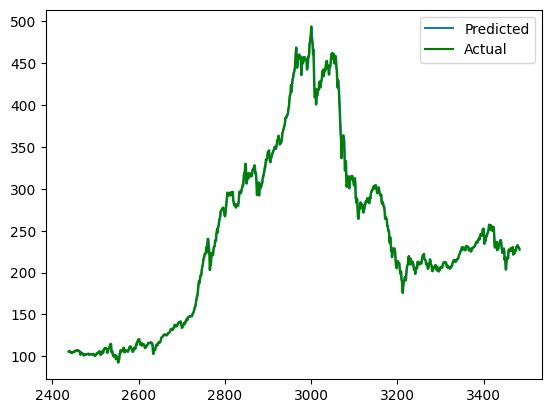

In [54]:
plt.plot(predicted_df['Open'], label = 'Predicted')
plt.plot(test_data['Open'], label='Actual', color = 'green')
plt.legend()
plt.show()

## Forecasting 

In [56]:
fredict_day = 30
history = [np.log(x) for x in df['Open']]
future_30_days = list()
y_test = list(np.log(df['Open']))
for t in range(fredict_day):
    model = ARIMA(history, order=(0,1,0), seasonal_order = (1,0,0,12))
    model_fit = model.fit()
    yhat_p = model_fit.predict(start=(len(history)+1), end=(len(history)+2))[0]
    future_30_days.append(np.exp(yhat_p))
    history.append(yhat_p)

c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


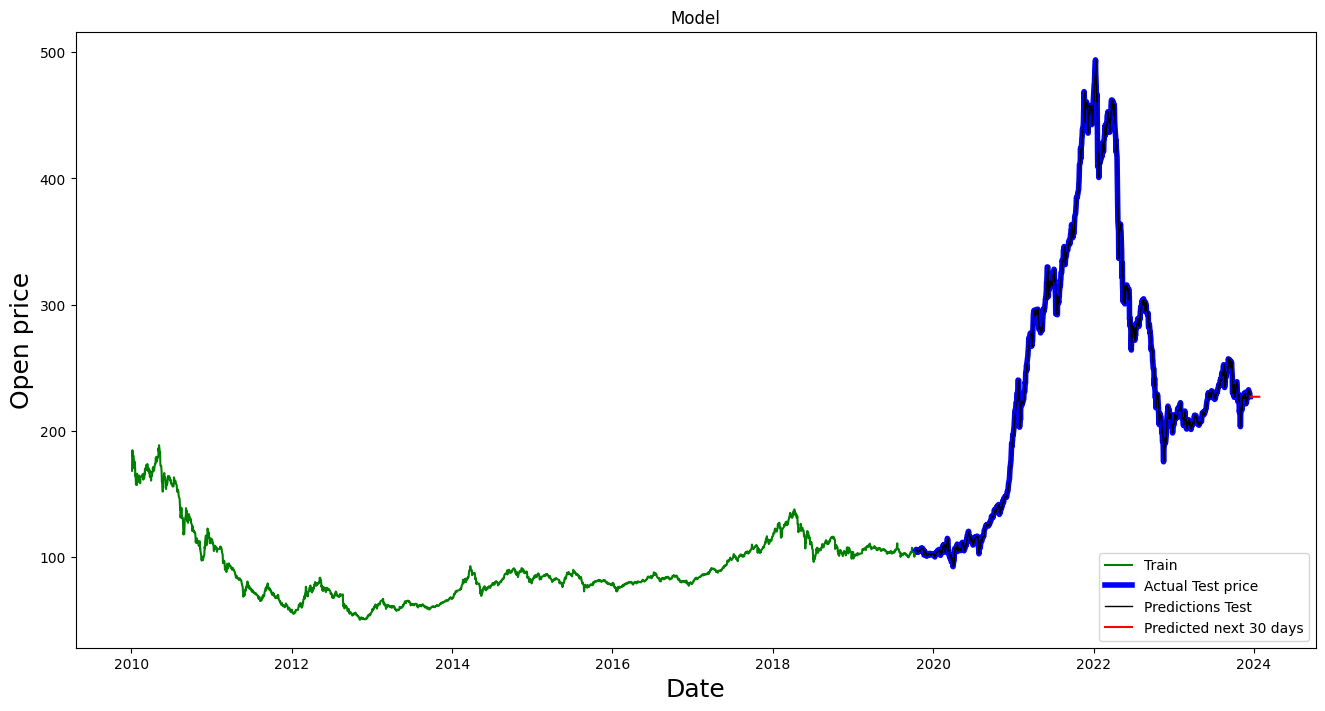

In [58]:
predicted_date = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(future_30_days, index=predicted_date["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price', fontsize=18)
plt.plot(train_data['Date'],train_data['Open'], color='green')
plt.plot(test_data['Date'],test_data[['Open']], color='blue', lw=4)
plt.plot(predicted_df['Date'], predicted_df['Open'], color='black',lw=1)
plt.plot(future_30_days_df.index, future_30_days_df['Open'], label='Predicted next 30 days', color = 'red')
plt.legend(['Train', 'Actual Test price', 'Predictions Test', 'Predicted next 30 days'], loc='lower right')
plt.show()